<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/augment8%2Fresnet-single/ResNet_base_model_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
!cp '/content/drive/My Drive/2020 Kaggle Study/data/Copy of train.npy' train.npy

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
warnings.filterwarnings("ignore")
# style 설정
plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)


import tensorflow as tf
import os
import tensorflow_datasets as tfds
from sklearn.model_selection import KFold
import pickle
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTO = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 데이터 받아오기

In [0]:
#train = np.load('train.npy')
train = np.load('train.npy')

In [56]:
train.shape

(76345, 40, 40, 15)

In [57]:
def preprocess(data):
    land_type_data = data[:,:,:,9]
    data[:,:,:,9] = np.where(land_type_data//100 == 2, 0.7,
                             np.where(land_type_data//100 == 3, 0.3,
                                      land_type_data//100))
    return data


is_valid = (train[:,:,:,-1].reshape(-1, 1600) < 0).sum(axis=1) == 0
is_valid = is_valid & ((train[:,:,:,-1].reshape(-1, 1600) >= 0.1).sum(axis=1) >= 50)
train = train[is_valid]  # (-1, 40, 40, 15)
train = preprocess(train)
train.shape

(30662, 40, 40, 15)

#모델 만들기

In [0]:
def create_model():
    inputs=Input((40, 40, 10))
    
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(inputs)
    conv0=Dropout(0.5)(conv0)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    conv=Dropout(0.5)(conv)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    conv=Dropout(0.5)(conv)
    concat=concatenate([concat, conv], axis=3)

    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        conv=Dropout(0.5)(conv)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

## 데이터 제네레이터 만들기

In [0]:
train.shape

(30662, 40, 40, 15)

In [0]:
import tensorflow as tf, tensorflow.keras.backend as K
import math

def get_mat():
    # returns 3x3 transformmatrix which transforms indicies
    # CONVERT DEGREES TO RADIANS
    rotation = tf.random.uniform([1], minval=0, maxval=4, dtype=tf.dtypes.int32, seed=None, name=None) / 2 * math.pi

    # ROTATION MATRIX
    rotation = tf.random.uniform([1], minval=0, maxval=4, dtype=tf.dtypes.int32, seed=None, name=None)
    rotation = tf.cast(rotation, 'float32')
    rotation = rotation * math.pi / 2.
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # TRANSPOSE MATRIX 
    de_t = tf.random.uniform([1], minval = 0, maxval = 2, dtype = tf.int32)
    de_t = tf.cast(de_t, 'float32')
    forty = tf.constant([40],dtype='float32')
    transpose_matrix = tf.reshape( tf.concat([1 - de_t, -de_t, de_t, -de_t, 1 - de_t, de_t, zero, zero, one], axis = 0),[3,3])   
    return K.dot(rotation_matrix, transpose_matrix)

def transform(train_x,train_y):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = 40
    # GET TRANSFORMATION MATRIX
    m = get_mat()
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM)
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM])
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    train_x_img = tf.gather_nd(train_x,tf.transpose(idx3))
    train_y_img = tf.gather_nd(train_y,tf.transpose(idx3))

    return tf.reshape(train_x_img,[DIM,DIM,10]),tf.reshape(train_y_img,[DIM,DIM,1])

def get_training_dataset(dataset,batch_size = None):
    dataset = dataset.with_options(tf.data.Options())
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset,batch_size = None):
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [121]:
zero = tf.constant([0],dtype='float32')
one = tf.constant([1],dtype='float32')

de_t = tf.random.uniform([1], minval = 0, maxval = 2, dtype = tf.int32)
de_t = tf.cast(de_t, 'float32')
forty = tf.constant([40],dtype='float32')
tf.reshape( tf.concat([1 - de_t, -de_t, de_t, -de_t, 1 - de_t, de_t, zero, zero, one-de_t], axis = 0),[3,3])


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0., -1.,  1.],
       [-1.,  0.,  1.],
       [ 0.,  0.,  0.]], dtype=float32)>

(8, 40, 40, 10)
(8, 40, 40, 10)
(8, 40, 40, 10)


<Figure size 1080x504 with 0 Axes>

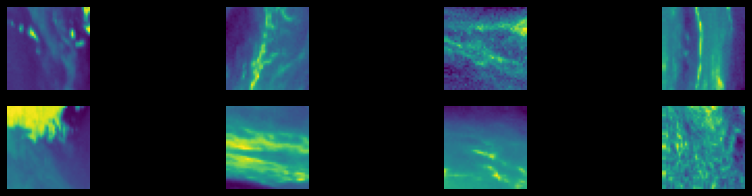

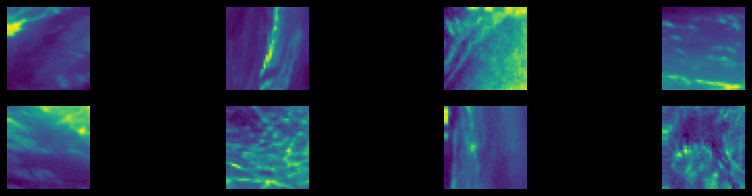

In [123]:
x_train =train[:1000,:,:,:10]
y_train = train[:1000,:,:,-1].reshape(-1,40,40,1)

train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_batches = get_training_dataset(train_batches, batch_size = 8)

n = 0 
for (img_x,label) in train_batches:
    plt.figure(figsize=(15,int(15*2/4)))
    print(img_x.shape)
    if n == 1:
        for j in range(8):
            plt.subplot(4,4,j+1)
            plt.axis('off')
            plt.imshow(img_x[j,:,:,4])
    if n == 2:
        for j in range(8):
            plt.subplot(4,4,j+1+8)
            plt.axis('off')
            plt.imshow(img_x[j,:,:,4])
    if n == 2:
        break
    n = n+1

In [0]:

from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score
def create_model():
    inputs=Input((40, 40, 10))
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)

    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
### tensor로 score matric 구현

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def custom_mae(y_true, y_pred):
    y_error = y_pred - y_true
    bool_idx = tf.less_equal(0.1,y_true)
    len_mae = tf.reduce_sum(tf.cast(bool_idx, tf.float32))
    socre = tf.math.abs(y_error)
    mae = tf.keras.backend.switch(bool_idx, socre, 0)
    return tf.divide(tf.math.reduce_sum(mae), len_mae)

def custum_f1score(y_true, y_pred):
    bool_true = tf.less_equal(0.1,y_true)
    y_true = tf.where(bool_true, 1., 0.)
    bool_pred = tf.less_equal(0.1,y_pred)
    y_pred = tf.where(bool_pred, 1., 0.)
    return(f1_metric(y_true, y_pred))


def maeOverFscore(y_true, y_pred):
    f1_score = custum_f1score(y_true, y_pred) + 1e-07
    return tf.divide(custom_mae(y_true, y_pred), f1_score)

In [0]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=7777)

model_number = 0
histories = []
for train_idx, val_idx in k_fold.split(train):
    print(f'Fold{model_number + 1}')
    #x_val, y_val = train[val_idx, :, :, :10], train[val_idx, :, :, -1]
    models = []
    ### TPU 할당 및 초기화-------------------
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    ### 모델 생성 및 compile-------------------
    with strategy.scope():
        model = create_model()
        model.compile(optimizer = 'adam',loss = 'mae',
        metrics=[maeOverFscore, custum_f1score, custom_mae]
        )
    ### 콜백 생성-------------------
    callbacks_list = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3,
            factor=0.9
        ),

        tf.keras.callbacks.ModelCheckpoint(
            filepath = f'/content/drive/My Drive/2020 Kaggle Study/deagwon/resnet_augment8/restnet_model_{model_number}.h5',
            monitor='val_maeOverFscore',
            save_best_only=True
        )
    ]
    # batch_dataset 만들기------------------
    batch_size = 64
    #train_batch
    train_dataset = tf.data.Dataset.from_tensor_slices((train[train_idx, :, :, :10],
                                                        train[train_idx, :, :, -1]))
    train_dataset = get_training_dataset(train_dataset,
                                         batch_size = batch_size)
    #validation_batch
    validation_dataset = tf.data.Dataset.from_tensor_slices((train[val_idx, :, :, :10],
                                        train[val_idx, :, :, -1]))
    
    validation_dataset = get_validation_dataset(validation_dataset,
                                                batch_size = batch_size)
    ### model.fit-------------------
    history = model.fit(train_dataset, epochs=50,
            steps_per_epoch = len(train[train_idx, :, :, :10]) * 8 // batch_size,
            validation_data=validation_dataset,
            callbacks=callbacks_list
            )
    
    with open(f'/content/drive/My Drive/2020 Kaggle Study/deagwon/resnet_augment8/histtory_{model_number}', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

    model_number = model_number + 1
    ### model append -------------------

Fold1


INFO:tensorflow:Initializing the TPU system: grpc://10.12.160.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.160.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
3066/3066 [==============================] - 136s 44ms/step - maeOverFscore: 2.1085 - loss: 0.2461 - custum_f1score: 0.6957 - custom_mae: 1.4488 - val_maeOverFscore: 1.9231 - val_loss: 0.2305 - val_custum_f1score: 0.7318 - val_custom_mae: 1.4091 - lr: 0.0010
Epoch 2/50
3066/3066 [==============================] - 127s 41ms/step - maeOverFscore: 1.8643 - loss: 0.2282 - custum_f1score: 0.7307 - custom_mae: 1.3651 - val_maeOverFscore: 1.8682 - val_loss: 0.2251 - val_custum_f1score: 0.7358 - val_custom_mae: 1.3755 - lr: 0.0010
Epoch 3/50
3066/3066 [==============================] - 126s 41ms/step - maeOverFscore: 1.7950 - loss: 0.2239 - custum_f1score: 0.7443 - custom_mae: 1.3396 - val_maeOverFscore: 1.8862 - val_loss: 0.2285 - val_custum_f1score: 0.7333 - val_custom_mae: 1.3791 - lr: 0.0010
Epoch 4/50
3066/3066 [==============================] - 131s 43ms/step - maeOverFscore: 1.7467 - loss: 0.2209 - custum_f1score: 0.7542 - custom_mae: 1.3220 - val_maeOverFscore: 1.8556 - val_

INFO:tensorflow:Initializing the TPU system: grpc://10.12.160.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.160.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
3066/3066 [==============================] - 136s 44ms/step - maeOverFscore: 2.1304 - loss: 0.2483 - custum_f1score: 0.6959 - custom_mae: 1.4622 - val_maeOverFscore: 2.0285 - val_loss: 0.2283 - val_custum_f1score: 0.6858 - val_custom_mae: 1.3921 - lr: 0.0010
Epoch 2/50
3066/3066 [==============================] - 128s 42ms/step - maeOverFscore: 1.8828 - loss: 0.2302 - custum_f1score: 0.7307 - custom_mae: 1.3774 - val_maeOverFscore: 1.9482 - val_loss: 0.2322 - val_custum_f1score: 0.7138 - val_custom_mae: 1.3973 - lr: 0.0010
Epoch 3/50
3066/3066 [==============================] - 128s 42ms/step - maeOverFscore: 1.8092 - loss: 0.2253 - custum_f1score: 0.7433 - custom_mae: 1.3475 - val_maeOverFscore: 1.8549 - val_loss: 0.2205 - val_custum_f1score: 0.7155 - val_custom_mae: 1.3379 - lr: 0.0010
Epoch 4/50
3066/3066 [==============================] - 128s 42ms/step - maeOverFscore: 1.7629 - loss: 0.2227 - custum_f1score: 0.7528 - custom_mae: 1.3312 - val_maeOverFscore: 1.8147 - val_

INFO:tensorflow:Initializing the TPU system: grpc://10.12.160.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.160.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
3066/3066 [==============================] - 135s 44ms/step - maeOverFscore: 2.1041 - loss: 0.2431 - custum_f1score: 0.6939 - custom_mae: 1.4492 - val_maeOverFscore: 1.9458 - val_loss: 0.2303 - val_custum_f1score: 0.7173 - val_custom_mae: 1.3884 - lr: 0.0010
Epoch 2/50
3066/3066 [==============================] - 128s 42ms/step - maeOverFscore: 1.8694 - loss: 0.2279 - custum_f1score: 0.7297 - custom_mae: 1.3671 - val_maeOverFscore: 1.9419 - val_loss: 0.2328 - val_custum_f1score: 0.7258 - val_custom_mae: 1.3973 - lr: 0.0010
Epoch 3/50
3066/3066 [==============================] - 129s 42ms/step - maeOverFscore: 1.7980 - loss: 0.2238 - custum_f1score: 0.7446 - custom_mae: 1.3431 - val_maeOverFscore: 1.7966 - val_loss: 0.2301 - val_custum_f1score: 0.7445 - val_custom_mae: 1.3373 - lr: 0.0010
Epoch 4/50
3066/3066 [==============================] - 128s 42ms/step - maeOverFscore: 1.7550 - loss: 0.2209 - custum_f1score: 0.7525 - custom_mae: 1.3251 - val_maeOverFscore: 1.8263 - val_

INFO:tensorflow:Initializing the TPU system: grpc://10.12.160.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.160.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
3066/3066 [==============================] - 135s 44ms/step - maeOverFscore: 2.1166 - loss: 0.2432 - custum_f1score: 0.6900 - custom_mae: 1.4500 - val_maeOverFscore: 2.0505 - val_loss: 0.2416 - val_custum_f1score: 0.7015 - val_custom_mae: 1.4333 - lr: 0.0010
Epoch 2/50
3066/3066 [==============================] - 129s 42ms/step - maeOverFscore: 1.8607 - loss: 0.2261 - custum_f1score: 0.7303 - custom_mae: 1.3618 - val_maeOverFscore: 1.9007 - val_loss: 0.2400 - val_custum_f1score: 0.7284 - val_custom_mae: 1.3879 - lr: 0.0010
Epoch 3/50
3066/3066 [==============================] - 129s 42ms/step - maeOverFscore: 1.7925 - loss: 0.2219 - custum_f1score: 0.7431 - custom_mae: 1.3370 - val_maeOverFscore: 1.8631 - val_loss: 0.2375 - val_custum_f1score: 0.7444 - val_custom_mae: 1.3888 - lr: 0.0010
Epoch 4/50
3066/3066 [==============================] - 129s 42ms/step - maeOverFscore: 1.7466 - loss: 0.2188 - custum_f1score: 0.7524 - custom_mae: 1.3187 - val_maeOverFscore: 1.8181 - val_

In [4]:
#read history and model
histories = []
models = []
for i in range(3):
    i = i+1
    history= pickle.load(open(f'/content/drive/My Drive/2020 Kaggle Study/deagwon/resnet_augment8/histtory_{i}', 'rb'))
    model = tf.keras.models.load_model(f'/content/drive/My Drive/2020 Kaggle Study/deagwon/resnet_augment8/restnet_model_{i}.h5', compile = False)
    histories.append(history)
    models.append(model)

FileNotFoundError: ignored

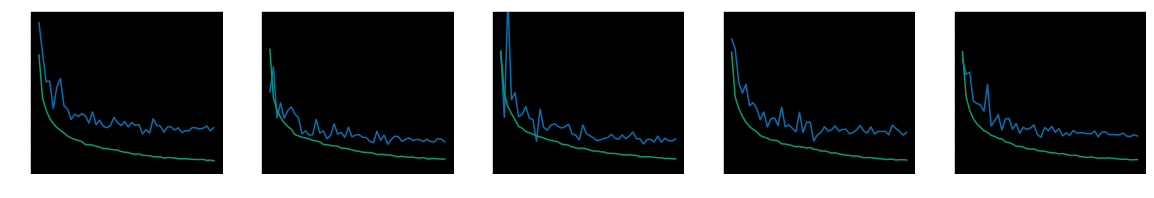

In [0]:
#maeOverFscore
print('maeOverFscore')
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(histories[i]['val_maeOverFscore'])
    plt.plot(histories[i]['maeOverFscore'])
    plt.ylim([1.6,2.3])
plt.show()

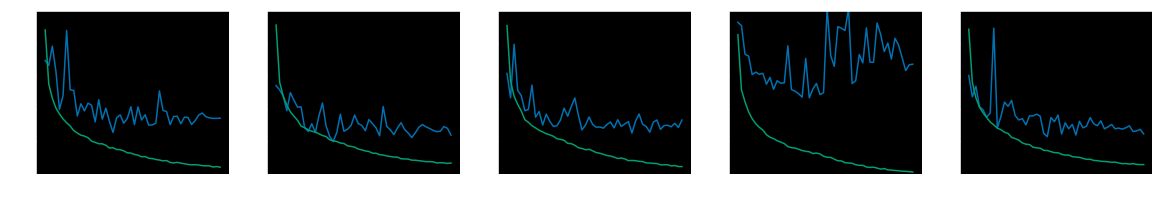

In [0]:
# loss
print('loss')
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(histories[i]['val_loss'])
    plt.plot(histories[i]['loss'])
    plt.ylim([0.20,0.25])
plt.show()

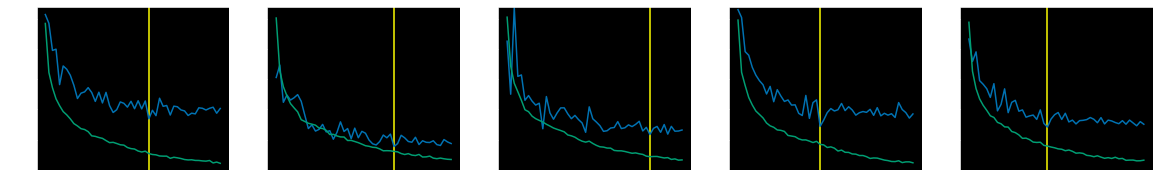

In [0]:
# custom_mae
print('custom_mae')
plt.figure(figsize = (20,3))
for i in range(5):
    min_ndex = np.argmin(histories[i]['val_custom_mae'])
    plt.subplot(1,5,i+1)
    plt.plot(histories[i]['val_custom_mae'])
    plt.plot(histories[i]['custom_mae'])
    plt.vlines(min_ndex, ymin = 1.20,ymax=1.50, colors = 'yellow')
    plt.ylim([1.20,1.47])
plt.show()

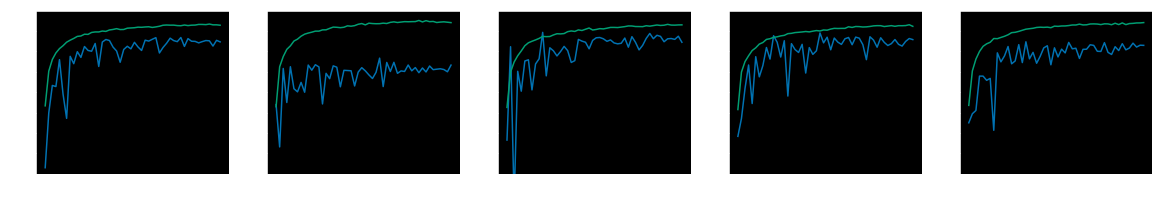

In [0]:
# f1_metric
print('f1_metric')
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(histories[i]['val_f1_metric'])
    plt.plot(histories[i]['f1_metric'])
    plt.ylim([0.65,0.73])
plt.show()

## submission

In [0]:
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test = preprocess(test)
test.shape

(2416, 40, 40, 14)

In [0]:
# 5개 모델 앙상블 예측 평균 내기
preds = []
for model in models:
    model.compile(optimizer = 'adam',loss = 'mae',  metrics=[maeOverFscore, f1_metric, custom_mae])
    preds.append(model.predict(test[:,:,:,:10]))
pred = sum(preds)/len(preds)

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')
submission.iloc[:,1:] = pred.reshape(-1,1600)
submission.to_csv('submission.csv', index = False)
submission

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,px_10,px_11,px_12,px_13,px_14,px_15,px_16,px_17,px_18,px_19,px_20,px_21,px_22,px_23,px_24,px_25,px_26,px_27,px_28,px_29,px_30,px_31,px_32,px_33,px_34,px_35,px_36,px_37,px_38,px_39,...,px_1561,px_1562,px_1563,px_1564,px_1565,px_1566,px_1567,px_1568,px_1569,px_1570,px_1571,px_1572,px_1573,px_1574,px_1575,px_1576,px_1577,px_1578,px_1579,px_1580,px_1581,px_1582,px_1583,px_1584,px_1585,px_1586,px_1587,px_1588,px_1589,px_1590,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.011216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.024766,0.751328,0.00339,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
1,029858_02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.136175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
2,029858_03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.420303,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
3,029858_05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993811,1.125023,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.334730,2.106717,5.883943,1.500862,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
4,029858_07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.862609,0.96589,1.148732,2.081965,2.995235,2.969595,1.800625,0.88655,0.726014,1.360684,2.361010,4.525452,4.637113,3.575653,5.874806,9.083761,11.954782,14.805521,12.083727,10.755697,6.835498,5.045813,7.73668,11.693479,5.451712,1.30602,0.392692,0.264137,0.321593,0.71928,1.354828,1.946476,1.397042,0.823059,0.76108,1.507544,3.541018,3.348232,2.239128,1.07867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411